### Code Hist.

 - CODE : KIER Data_전처리 (결측 제거)  
 - DESC  
   &ensp; : int_Domain 코드의 변경에 따라,   
   &emsp; KIER 에너지 사용량 데이터를 보간  

   &emsp; [보간 방식]  
   &emsp; 아래 방법 중 3-2, 1을 순서대로 수행  
   &emsp; A. 순시값을 보간하는 방법은 3가지로 제안 가능  
   &emsp; 1) 단순 Linear 보간 (앞뒤 평균치)  
   &emsp;&emsp; [Not Recommanded] 매우 긴 구간의 결측을 커버하기에 부적절  
   &emsp;&emsp; (양 끝이 0인 경우, 해당 구간을 제대로 보간 불가)  
   &emsp; 2) 직전 주 동일시간 사용량  
   &emsp;&emsp; 나쁘지 않은 방법이지만, 직전 주의 데이터가 존재하지 않을 경우 보간 불가  
   &emsp;&emsp; (데이터 상 첫 주 케이스 등)  
   &emsp; 3-1) 해당 동일년도/동일월/동일요일/동일시간의 평균 사용량  
   &emsp;&emsp;&emsp; 나쁘지 않은 방법이지만, 과정이 조금 복잡해짐  
   &emsp; 3-2) 해당 동일 일시의 348 세대의 평균 사용량  
   &emsp;&emsp;&emsp; c-1보다 기대되는 적용 데이터량이 많음.  
   &emsp;&emsp;&emsp; 한파/폭염/우천 등 예외적인 날씨에 따른 사용량 변동의 영향이 적어질 것으로 판단.  

 - DATE  
    &ensp; 2023-10-12 Created  
    &ensp; 2023-11-21 Code 최신화  
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; 1) 기존 모듈화된 함수 사용  
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; 2) 기존 KIER 변환 관련 코드를 모두 통합  
    &ensp; 2024-01-19 Code 개선  
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; 1) 공통코드 사용 경로 개선, Raw로 저장  
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; 2) HOT (온수 사용량) 전용 Code 작성  
    &ensp; 2024-01-30 Code 개선 후 백업  
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; 1) 순시사용량 보간 코드 작성 (미완)  
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; 2) 백업 후 코드 최적화    
    &ensp; 2024-02-05 Code 개선  
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; 1) 순시사용량 보간 코드 작성 (Method 02 1차 완성)  
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; 2) 보간 전 단계 아래 이상치에 대한 NaN 처리  
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; a) Resample시 발생하는 공백   
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; b-1) 시점 n의 적산량이 0이고 시점 n + 1의 적산량이 정상 경우  
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; b-2) 시점 n의 순시량이 음수인 경우  
    &ensp; 2024-02-07 Code 개선  
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; 1) 결측 처리 부분 정확도 개선  
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; 2) Raw Data 상 결측치가 15% 이상일 경우, 해당 데이터를 사용하지 않는 부분 추가  
    &ensp; 2024-07-30 Code 개선 : Process 전 결측치 산정 Code 추가  

## 01. Code

### 01-01. Init

#### 01-01-01. Init_Module Import

#### Module import

In [69]:
#region Import_Basic Module
## Basic
import os, sys, warnings
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.path.dirname(os.path.abspath('./__file__'))
sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname('./__file__'))))
warnings.filterwarnings('ignore')

import numpy as np, pandas as pd
from pandas import DataFrame, Series
pd.options.display.float_format = '{:.10f}'.format

import math, random

## Datetime
import time, datetime as dt
from datetime import datetime, date, timedelta

## glob
import glob, requests, json
from glob import glob

## 시각화
import matplotlib.pyplot as plt, seaborn as sns
# %matplotlib inline
plt.rcParams['figure.figsize'] = [10, 8]

from scipy import stats

## Split, 정규화
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# K-Means 알고리즘
from sklearn.cluster import KMeans, MiniBatchKMeans

# Clustering 알고리즘의 성능 평가 측도
from sklearn import metrics
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score, adjusted_rand_score, silhouette_score, rand_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics.cluster import contingency_matrix

## For Web
import urllib
from urllib.request import urlopen
from urllib.parse import urlencode, unquote, quote_plus
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup

import tqdm
from tqdm.notebook import tqdm
#endregion Import_Basic Module

In [70]:
## Import_DL
str_tar = "tf"
## For Torch
if str_tar == "torch":
    import torch, torch.nn as nn
    from torch.nn.utils import weight_norm
    print("Torch Imported")
## For TF
elif str_tar == "tf":
    import tensorflow as tf, tensorflow_addons as tfa
    from keras.callbacks import EarlyStopping, ModelCheckpoint
    from keras.models import Sequential, load_model
    from keras_flops import get_flops
    print("Tensorflow Imported")
else:
    print("Error : Cannot be used except for Keywords")
    print(" : torch / tf")

Tensorflow Imported


In [71]:
## Import_Local
from Src_Dev_Common import Data_Datetime as com_date, Data_Preprocessing as com_Prep, KMA_Weather as com_KMA, KECO_AirKor as com_KECO, KASI_Holiday as com_Holi, KIER_Usage_M02 as com_KIER_M02

### 01-01-02. Config (Directory, Params)

In [72]:
## Init_config
SEED = 42

np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)
os.environ["PYTHONHASHSEED"], os.environ['TF_DETERMINISTIC_OPS'] = str(SEED), "1"

In [73]:
## Define Todate str
str_now_ymd = pd.datetime.now().date()
str_now_y, str_now_m, str_now_d = pd.datetime.now().year, pd.datetime.now().month, pd.datetime.now().day
str_now_hr, str_now_min = pd.datetime.now().hour, pd.datetime.now().minute

print(pd.datetime.now())
print(str(str_now_y) + " / " + str(str_now_m)  + " / " + str(str_now_d))
print(str(str_now_hr) + " : " + str(str_now_min))

2024-08-01 08:11:12.280846
2024 / 8 / 1
8 : 11


In [74]:
## Dict_Domain
int_domain = 5

## Domain, ACCU/INST Column
str_domain, str_col_accu, str_col_inst = com_KIER_M02.create_domain_str(int_domain)
## Directory Root
str_dirData, str_dir_raw, str_dir_cleansed, str_dirName_bld, str_dirName_h = com_KIER_M02.create_dir_str(str_domain)

## File
str_fileRaw, str_fileRaw_hList = str('KIER_RAW_' + str_domain + '_H_ID_Adopted.csv'), str('KIER_hList_Common.csv')

print(str(os.listdir(str_dirData)) + "\n")
print(os.listdir(str_dirName_h))

5 : GAS
['.ipynb_checkpoints', 'BS_CONFIGURATION_202309251452.csv', 'DATE_1M_2023-10-20.csv', 'KIER 전처리 현황_2024-06-25.xlsx', 'KIER_0_Raw', 'KIER_1_Cleansed', 'KIER_2_BLD', 'KIER_3_H_ELEC', 'KIER_3_H_GAS', 'KIER_3_H_HEAT', 'KIER_3_H_HOT_FLOW', 'KIER_3_H_HOT_HEAT', 'KIER_3_H_WATER', 'KIER_ASOS_WEATHER_DAILY_202309251521.csv', 'KIER_ASOS_WEATHER_HOUR_202309251521.csv', 'KIER_DATA_OLD', 'KIER_ETC', 'KIER_hList_Comparison_2024-06-26.xlsx', 'KIER_List_Table_Column_2023-09-25.xlsx', 'KIER_Query_2023-09-25.txt', 'KMA_ASOS_119_2010_2023_1st_to CSV.csv', '[IITP] 데이터 테이블 정리 (공유 원본).docx']

['KIER_GAS_561-1-1_ACCU_01_Raw.csv', 'KIER_GAS_561-1-1_INST_01_10min.csv', 'KIER_GAS_561-1-2_ACCU_01_Raw.csv', 'KIER_GAS_561-1-2_INST_01_10min.csv', 'KIER_GAS_561-1-3_ACCU_01_Raw.csv', 'KIER_GAS_561-1-3_INST_01_10min.csv', 'KIER_GAS_561-1-4_ACCU_01_Raw.csv', 'KIER_GAS_561-1-4_INST_01_10min.csv', 'KIER_GAS_561-10-1_ACCU_01_Raw.csv', 'KIER_GAS_561-10-1_INST_01_10min.csv', 'KIER_GAS_561-10-2_ACCU_01_Raw.csv', 'KIE

#### 02-01. KIER (hList)

In [75]:
## "KIER_01-01_Data_hList.ipynb"로부터 만들어진 Bld/F/H List
df_kier_hList = pd.read_csv(str_dir_raw + str_fileRaw_hList, index_col = 0)
# print(df_kier_hList.shape, ' /// ', df_kier_hList.columns)
# df_kier_hList

## 01-02. Data Load (df_raw)

### 01-02-01. KIER (Energy Usage : INST Combined)

In [76]:
## Load Intergrated INST Usage
str_file_inst = 'KIER_' + str_domain + '_INST_10MIN.csv'

df_INST_Intergrated = pd.read_csv(str_dirName_h + str_file_inst, index_col = 0)
df_INST_Intergrated

,YEAR,MONTH,DAY,HOUR,MINUTE,GAS_INST_FLOW_561-1-1,GAS_INST_FLOW_561-1-2,GAS_INST_FLOW_561-1-3,GAS_INST_FLOW_561-1-4,GAS_INST_FLOW_561-2-1,...,GAS_INST_FLOW_563-22-3,GAS_INST_FLOW_563-22-4,GAS_INST_FLOW_563-22-5,GAS_INST_FLOW_563-22-6,GAS_INST_FLOW_563-23-1,GAS_INST_FLOW_563-23-2,GAS_INST_FLOW_563-23-3,GAS_INST_FLOW_563-23-4,GAS_INST_FLOW_563-24-1,GAS_INST_FLOW_563-24-2
0,2022,8,26,20,50,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022,8,26,21,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022,8,26,21,10,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022,8,26,21,20,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022,8,26,21,30,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96124,2024,6,24,9,30,0.0000000000,0.0000000000,0.0000000000,NaN,0.0000000000,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
96125,2024,6,24,9,40,0.0000000000,0.0000000000,0.0000000000,NaN,0.0000000000,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
96126,2024,6,24,9,50,0.0000000000,0.0000000000,0.0000000000,NaN,0.0000000000,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
96127,2024,6,24,10,0,0.0000000000,NaN,NaN,NaN,NaN,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000


In [77]:
## 사용량 평균 및 합계 Column 추가
list_col = df_INST_Intergrated.columns[5:]
print(list_col)
df_kier_Calc = df_INST_Intergrated[list_col]

df_INST_Intergrated['MEAN_OF_INST'], df_INST_Intergrated['SUM_OF_INST'] = df_kier_Calc.mean(axis = 1), df_kier_Calc.sum(axis = 1)
print(df_INST_Intergrated.isnull().sum())
df_INST_Intergrated

Index(['GAS_INST_FLOW_561-1-1', 'GAS_INST_FLOW_561-1-2',
       'GAS_INST_FLOW_561-1-3', 'GAS_INST_FLOW_561-1-4',
       'GAS_INST_FLOW_561-2-1', 'GAS_INST_FLOW_561-2-2',
       'GAS_INST_FLOW_561-2-3', 'GAS_INST_FLOW_561-2-4',
       'GAS_INST_FLOW_561-3-1', 'GAS_INST_FLOW_561-3-2',
       ...
       'GAS_INST_FLOW_563-22-3', 'GAS_INST_FLOW_563-22-4',
       'GAS_INST_FLOW_563-22-5', 'GAS_INST_FLOW_563-22-6',
       'GAS_INST_FLOW_563-23-1', 'GAS_INST_FLOW_563-23-2',
       'GAS_INST_FLOW_563-23-3', 'GAS_INST_FLOW_563-23-4',
       'GAS_INST_FLOW_563-24-1', 'GAS_INST_FLOW_563-24-2'],
      dtype='object', length=348)
YEAR                          0
MONTH                         0
DAY                           0
HOUR                          0
MINUTE                        0
                          ...  
GAS_INST_FLOW_563-23-4     6903
GAS_INST_FLOW_563-24-1    13565
GAS_INST_FLOW_563-24-2     9560
MEAN_OF_INST               5789
SUM_OF_INST                   0
Length: 355, dtype: in

,YEAR,MONTH,DAY,HOUR,MINUTE,GAS_INST_FLOW_561-1-1,GAS_INST_FLOW_561-1-2,GAS_INST_FLOW_561-1-3,GAS_INST_FLOW_561-1-4,GAS_INST_FLOW_561-2-1,...,GAS_INST_FLOW_563-22-5,GAS_INST_FLOW_563-22-6,GAS_INST_FLOW_563-23-1,GAS_INST_FLOW_563-23-2,GAS_INST_FLOW_563-23-3,GAS_INST_FLOW_563-23-4,GAS_INST_FLOW_563-24-1,GAS_INST_FLOW_563-24-2,MEAN_OF_INST,SUM_OF_INST
0,2022,8,26,20,50,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000000000
1,2022,8,26,21,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000000000
2,2022,8,26,21,10,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000000000
3,2022,8,26,21,20,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000000000
4,2022,8,26,21,30,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96124,2024,6,24,9,30,0.0000000000,0.0000000000,0.0000000000,NaN,0.0000000000,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0004129794,0.1400000000
96125,2024,6,24,9,40,0.0000000000,0.0000000000,0.0000000000,NaN,0.0000000000,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0002409639,0.0800000000
96126,2024,6,24,9,50,0.0000000000,0.0000000000,0.0000000000,NaN,0.0000000000,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0003951368,0.1300000000
96127,2024,6,24,10,0,0.0000000000,NaN,NaN,NaN,NaN,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0003539823,0.0800000000


In [78]:
## 생성된 세대별 사용량 Data를 기반으로 결측치 계산
print(df_kier_Calc.isnull().sum())
df_kier_Calc

GAS_INST_FLOW_561-1-1      6418
GAS_INST_FLOW_561-1-2     11604
GAS_INST_FLOW_561-1-3      9701
GAS_INST_FLOW_561-1-4     15400
GAS_INST_FLOW_561-2-1      8801
                          ...  
GAS_INST_FLOW_563-23-2     9302
GAS_INST_FLOW_563-23-3     7377
GAS_INST_FLOW_563-23-4     6903
GAS_INST_FLOW_563-24-1    13565
GAS_INST_FLOW_563-24-2     9560
Length: 348, dtype: int64


,GAS_INST_FLOW_561-1-1,GAS_INST_FLOW_561-1-2,GAS_INST_FLOW_561-1-3,GAS_INST_FLOW_561-1-4,GAS_INST_FLOW_561-2-1,GAS_INST_FLOW_561-2-2,GAS_INST_FLOW_561-2-3,GAS_INST_FLOW_561-2-4,GAS_INST_FLOW_561-3-1,GAS_INST_FLOW_561-3-2,...,GAS_INST_FLOW_563-22-3,GAS_INST_FLOW_563-22-4,GAS_INST_FLOW_563-22-5,GAS_INST_FLOW_563-22-6,GAS_INST_FLOW_563-23-1,GAS_INST_FLOW_563-23-2,GAS_INST_FLOW_563-23-3,GAS_INST_FLOW_563-23-4,GAS_INST_FLOW_563-24-1,GAS_INST_FLOW_563-24-2
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96124,0.0000000000,0.0000000000,0.0000000000,NaN,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
96125,0.0000000000,0.0000000000,0.0000000000,NaN,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
96126,0.0000000000,0.0000000000,0.0000000000,NaN,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
96127,0.0000000000,NaN,NaN,NaN,NaN,NaN,NaN,0.0000000000,NaN,0.0000000000,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000


In [79]:
## 데이터의 총량
print("Total Data : ", len(df_kier_Calc) * len(list(df_kier_Calc.columns)))

## 결측치의 총량
print("Sum of Nan : ", df_kier_Calc.isna().sum().sum())

## 결측치의 비율
print("Rate of Nan : ", (df_kier_Calc.isna().sum().sum()) / (len(df_kier_Calc) * len(list(df_kier_Calc.columns))))

Total Data :  33452892
Sum of Nan :  3053254
Rate of Nan :  0.0912702554983886


### 순시사용량 1차 보간

In [80]:
for i in range(0, len(df_INST_Intergrated)) : df_INST_Intergrated.loc[i] = df_INST_Intergrated.loc[i].fillna(df_INST_Intergrated['MEAN_OF_INST'].loc[i])

print(df_INST_Intergrated.isna().sum())
## 마지막값이 0이므로 제외
# df_tmp = df_tmp[:-1]
df_INST_Intergrated

YEAR                         0
MONTH                        0
DAY                          0
HOUR                         0
MINUTE                       0
                          ... 
GAS_INST_FLOW_563-23-4    5789
GAS_INST_FLOW_563-24-1    5789
GAS_INST_FLOW_563-24-2    5789
MEAN_OF_INST              5789
SUM_OF_INST                  0
Length: 355, dtype: int64


,YEAR,MONTH,DAY,HOUR,MINUTE,GAS_INST_FLOW_561-1-1,GAS_INST_FLOW_561-1-2,GAS_INST_FLOW_561-1-3,GAS_INST_FLOW_561-1-4,GAS_INST_FLOW_561-2-1,...,GAS_INST_FLOW_563-22-5,GAS_INST_FLOW_563-22-6,GAS_INST_FLOW_563-23-1,GAS_INST_FLOW_563-23-2,GAS_INST_FLOW_563-23-3,GAS_INST_FLOW_563-23-4,GAS_INST_FLOW_563-24-1,GAS_INST_FLOW_563-24-2,MEAN_OF_INST,SUM_OF_INST
0,2022,8,26,20,50,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000000000
1,2022,8,26,21,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000000000
2,2022,8,26,21,10,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000000000
3,2022,8,26,21,20,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000000000
4,2022,8,26,21,30,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96124,2024,6,24,9,30,0.0000000000,0.0000000000,0.0000000000,0.0004129794,0.0000000000,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0004129794,0.1400000000
96125,2024,6,24,9,40,0.0000000000,0.0000000000,0.0000000000,0.0002409639,0.0000000000,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0002409639,0.0800000000
96126,2024,6,24,9,50,0.0000000000,0.0000000000,0.0000000000,0.0003951368,0.0000000000,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0003951368,0.1300000000
96127,2024,6,24,10,0,0.0000000000,0.0003539823,0.0003539823,0.0003539823,0.0003539823,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0003539823,0.0800000000


모든 값이 NaN이어서 평균 순시 사용량이 계산되지 않은 경우 존재 (ELEC 기준 약 1,372건)  
해당 부분은 단순 선형 보간을 진행

In [81]:
df_INST_Intergrated['MEAN_OF_INST'] = df_INST_Intergrated['MEAN_OF_INST'].interpolate()

In [82]:
## 사용량 컬럼에 대한 2차 보간 진행 (선형 보간된 평균 순시 사용량으로 보간)
for i in range(0, len(df_INST_Intergrated)):
    df_INST_Intergrated.loc[i] = df_INST_Intergrated.loc[i].fillna(df_INST_Intergrated['MEAN_OF_INST'].loc[i])
print(df_INST_Intergrated.isna().sum())
df_INST_Intergrated

YEAR                         0
MONTH                        0
DAY                          0
HOUR                         0
MINUTE                       0
                          ... 
GAS_INST_FLOW_563-23-4    3861
GAS_INST_FLOW_563-24-1    3861
GAS_INST_FLOW_563-24-2    3861
MEAN_OF_INST              3861
SUM_OF_INST                  0
Length: 355, dtype: int64


,YEAR,MONTH,DAY,HOUR,MINUTE,GAS_INST_FLOW_561-1-1,GAS_INST_FLOW_561-1-2,GAS_INST_FLOW_561-1-3,GAS_INST_FLOW_561-1-4,GAS_INST_FLOW_561-2-1,...,GAS_INST_FLOW_563-22-5,GAS_INST_FLOW_563-22-6,GAS_INST_FLOW_563-23-1,GAS_INST_FLOW_563-23-2,GAS_INST_FLOW_563-23-3,GAS_INST_FLOW_563-23-4,GAS_INST_FLOW_563-24-1,GAS_INST_FLOW_563-24-2,MEAN_OF_INST,SUM_OF_INST
0,2022,8,26,20,50,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000000000
1,2022,8,26,21,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000000000
2,2022,8,26,21,10,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000000000
3,2022,8,26,21,20,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000000000
4,2022,8,26,21,30,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96124,2024,6,24,9,30,0.0000000000,0.0000000000,0.0000000000,0.0004129794,0.0000000000,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0004129794,0.1400000000
96125,2024,6,24,9,40,0.0000000000,0.0000000000,0.0000000000,0.0002409639,0.0000000000,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0002409639,0.0800000000
96126,2024,6,24,9,50,0.0000000000,0.0000000000,0.0000000000,0.0003951368,0.0000000000,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0003951368,0.1300000000
96127,2024,6,24,10,0,0.0000000000,0.0003539823,0.0003539823,0.0003539823,0.0003539823,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0003539823,0.0800000000


In [83]:
print(df_INST_Intergrated.isna().sum())
## 마지막값이 0이므로 제외
# df_tmp = df_tmp[:-1]
str_file_inst = 'KIER_' + str_domain + '_INST_10MIN_1st_Mean.csv'
df_INST_Intergrated.to_csv(str_dirName_h + str_file_inst)
df_INST_Intergrated

YEAR                         0
MONTH                        0
DAY                          0
HOUR                         0
MINUTE                       0
                          ... 
GAS_INST_FLOW_563-23-4    3861
GAS_INST_FLOW_563-24-1    3861
GAS_INST_FLOW_563-24-2    3861
MEAN_OF_INST              3861
SUM_OF_INST                  0
Length: 355, dtype: int64


,YEAR,MONTH,DAY,HOUR,MINUTE,GAS_INST_FLOW_561-1-1,GAS_INST_FLOW_561-1-2,GAS_INST_FLOW_561-1-3,GAS_INST_FLOW_561-1-4,GAS_INST_FLOW_561-2-1,...,GAS_INST_FLOW_563-22-5,GAS_INST_FLOW_563-22-6,GAS_INST_FLOW_563-23-1,GAS_INST_FLOW_563-23-2,GAS_INST_FLOW_563-23-3,GAS_INST_FLOW_563-23-4,GAS_INST_FLOW_563-24-1,GAS_INST_FLOW_563-24-2,MEAN_OF_INST,SUM_OF_INST
0,2022,8,26,20,50,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000000000
1,2022,8,26,21,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000000000
2,2022,8,26,21,10,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000000000
3,2022,8,26,21,20,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000000000
4,2022,8,26,21,30,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96124,2024,6,24,9,30,0.0000000000,0.0000000000,0.0000000000,0.0004129794,0.0000000000,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0004129794,0.1400000000
96125,2024,6,24,9,40,0.0000000000,0.0000000000,0.0000000000,0.0002409639,0.0000000000,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0002409639,0.0800000000
96126,2024,6,24,9,50,0.0000000000,0.0000000000,0.0000000000,0.0003951368,0.0000000000,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0003951368,0.1300000000
96127,2024,6,24,10,0,0.0000000000,0.0003539823,0.0003539823,0.0003539823,0.0003539823,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0003539823,0.0800000000


In [84]:
## 그래도 보간되지 않은 부분은 단순 선형 보간
list_HID = df_kier_hList['HOUSE_ID'].drop_duplicates()
for house in list_HID:
    print(str(house) + " H")

    str_col_inst_h = str_col_inst + "_" + house
    df_INST_Intergrated[str_col_inst_h] = df_INST_Intergrated[str_col_inst_h].interpolate()

str_file_inst = 'KIER_' + str_domain + '_INST_10MIN_2st_Linear.csv'
df_INST_Intergrated.to_csv(str_dirName_h + str_file_inst)
df_INST_Intergrated

561-1-1 H
561-1-2 H
561-1-3 H
561-1-4 H
561-2-1 H
561-2-2 H
561-2-3 H
561-2-4 H
561-3-1 H
561-3-2 H
561-3-3 H
561-3-4 H
561-4-1 H
561-4-2 H
561-4-3 H
561-4-4 H
561-5-1 H
561-5-2 H
561-5-3 H
561-5-4 H
561-6-1 H
561-6-2 H
561-6-3 H
561-6-4 H
561-7-1 H
561-7-2 H
561-7-3 H
561-7-4 H
561-8-1 H
561-8-2 H
561-8-3 H
561-8-4 H
561-9-1 H
561-9-2 H
561-9-3 H
561-9-4 H
561-10-1 H
561-10-2 H
561-10-3 H
561-10-4 H
561-11-1 H
561-11-2 H
561-11-3 H
561-11-4 H
561-12-1 H
561-12-2 H
561-12-3 H
561-12-4 H
561-13-1 H
561-13-2 H
561-13-3 H
561-13-4 H
561-14-1 H
561-14-2 H
561-14-3 H
561-14-4 H
561-15-1 H
561-15-2 H
561-15-3 H
561-15-4 H
561-16-1 H
561-16-2 H
561-16-3 H
561-16-4 H
561-17-1 H
561-17-2 H
561-17-3 H
561-17-4 H
561-18-1 H
561-18-2 H
561-18-3 H
561-18-4 H
562-1-1 H
562-1-2 H
562-1-3 H
562-1-4 H
562-1-5 H
562-1-6 H
562-2-1 H
562-2-2 H
562-2-3 H
562-2-4 H
562-2-5 H
562-2-6 H
562-3-1 H
562-3-2 H
562-3-3 H
562-3-4 H
562-3-5 H
562-3-6 H
562-4-1 H
562-4-2 H
562-4-3 H
562-4-4 H
562-4-5 H
562-4-6 H
562-

,YEAR,MONTH,DAY,HOUR,MINUTE,GAS_INST_FLOW_561-1-1,GAS_INST_FLOW_561-1-2,GAS_INST_FLOW_561-1-3,GAS_INST_FLOW_561-1-4,GAS_INST_FLOW_561-2-1,...,GAS_INST_FLOW_563-22-5,GAS_INST_FLOW_563-22-6,GAS_INST_FLOW_563-23-1,GAS_INST_FLOW_563-23-2,GAS_INST_FLOW_563-23-3,GAS_INST_FLOW_563-23-4,GAS_INST_FLOW_563-24-1,GAS_INST_FLOW_563-24-2,MEAN_OF_INST,SUM_OF_INST
0,2022,8,26,20,50,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000000000
1,2022,8,26,21,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000000000
2,2022,8,26,21,10,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000000000
3,2022,8,26,21,20,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000000000
4,2022,8,26,21,30,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96124,2024,6,24,9,30,0.0000000000,0.0000000000,0.0000000000,0.0004129794,0.0000000000,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0004129794,0.1400000000
96125,2024,6,24,9,40,0.0000000000,0.0000000000,0.0000000000,0.0002409639,0.0000000000,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0002409639,0.0800000000
96126,2024,6,24,9,50,0.0000000000,0.0000000000,0.0000000000,0.0003951368,0.0000000000,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0003951368,0.1300000000
96127,2024,6,24,10,0,0.0000000000,0.0003539823,0.0003539823,0.0003539823,0.0003539823,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0003539823,0.0800000000


Text(0.5, 1.0, 'Instantaneous Electric Usage in certain household')

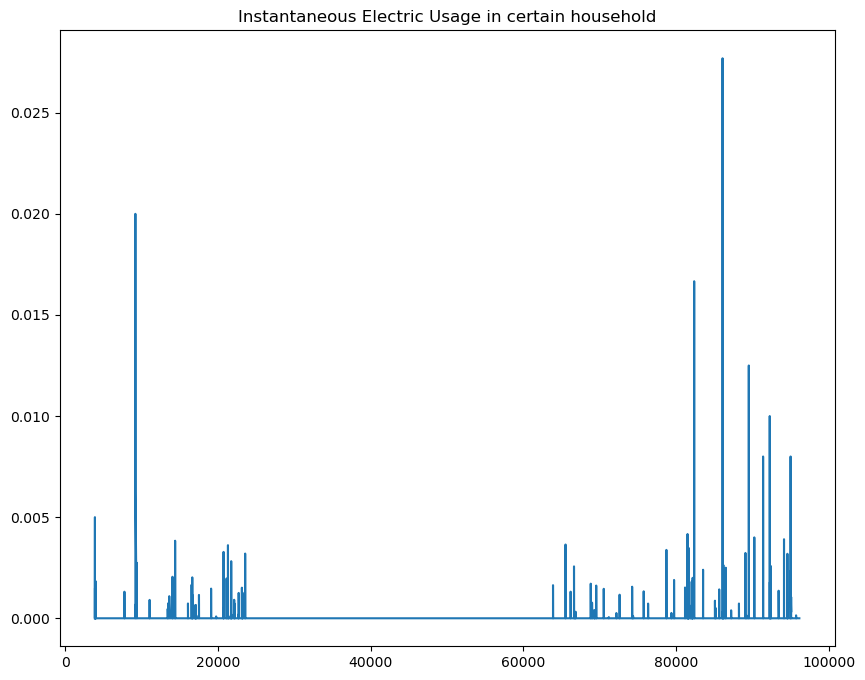

In [85]:
## 데이터 확인
plt.plot(df_INST_Intergrated[str_col_inst + '_561-1-1'])
plt.title('Instantaneous Electric Usage in certain household')